# Summmary


<p>
The goal of this project is to develop collaborative filtering models applying the Pyspark implementation of the Alternating Least Squares (ALS) algorithm to the Amazon consumer review data set and the movie ratings data set. The pyspark.mllib.recommendation module offers amazing methods
to give actual recommendations for individual users or products. The methods are the main focus here and the models developed here are not hyper tuned to get better outcomes.
</p>

<p>
Alternating Least Squares (ALS) is an algorithm widely used for collaborative filtering. The aim is to find users with common interests (products, clubs, activities ...). Recommendations are based on the “birds of a feather flock together”-assumption that people who share an opinion on one topic are more likely to share again an opinion on another new independent topic than with a random third person.</p> 

<p>
According to the 
<a href="https://spark.apache.org/docs/latest/mllib-collaborative-filtering.html" target="_blank">documentation</a> the implementation in spark.mllib has the following and other parameters: 
<p>
    
<ul>
<li>numBlocks is the number of blocks used to parallelize computation (set to -1 to auto-configure).</li>
<li>rank is the number of features to use (also referred to as the number of latent factors).</li>
<li>iterations is the number of iterations of ALS to run. ALS typically converges to a reasonable solution in 20 iterations or less.</li>
</ul> 

<p>
In the project are different tasks of data exploration and preparation carried out confirming the commonplace that 80 percent (or so) of all
Data Science is data cleaning. Using the Pyspark implementation 
of Apache Spark it is helpful to remind yourself that the various API's
are addressed with specific types of languages. The SQL-API is using of course SQL and the data frames and RDDs objects are employing different
domain specific languages.
</p> 


<p>
<h2>Spark system architecture</h2>
</p> 



<img src="spark_achitecture.png" alt="Smiley face" align="left"  style="margin-left: 0px; margin-right: 0px; margin-top: 20px; margin-bottom: 20px; float: left; width: 800px; height: 300px"> 


# Import packages

In [1574]:
# IPython
from IPython.display import display, HTML, display_html 
#usefull to display wide tables

# base packages
import numpy as np
import pandas as pd
import math
import random
import pathlib
import inspect
from datetime import datetime

# sklearn
from sklearn import preprocessing

# pyspark
from pyspark.sql import DataFrame
from pyspark.rdd import RDD
from pyspark.sql.types import StructType, StructField, IntegerType, \
StringType, BooleanType, DateType, FloatType
from pyspark.sql.functions import lower, col
from pyspark.sql import SparkSession
from pyspark.rdd import RDD
from pyspark.sql.functions import mean, stddev , col, avg, round
from pyspark.sql.types import IntegerType, FloatType
from pyspark.sql.functions import *
import pyspark.sql.functions as F
from pyspark.sql.functions import isnan

# machine learning in spark has got different libraries
# for different data objects

# machine learning on dataframes
# is based on pyspark.ml
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler

# machine learning on RDDs
# is based pyspark.mllib
from pyspark.mllib.classification import LogisticRegressionWithLBFGS
from pyspark.mllib.clustering import KMeans

# Collaborative Filtering - RDD-based API
# https://spark.apache.org/docs/latest/mllib-collaborative-filtering.html
from pyspark.mllib.recommendation import ALS, MatrixFactorizationModel, Rating

# data visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from pyspark_dist_explore import Histogram, hist, distplot, \
pandas_histogram

from handyspark import *

# Inspect working directory

In [1575]:
cwd = os.getcwd()
# print(cwd)

cwd_path = pathlib.Path.cwd()
# print(cwd_path)

home_path = pathlib.Path.home()
# print(home_path)

# Spark

### Spark context

In [1576]:
print("Spark version: {}".format(sc.version))
print("Python version: {}".format(sc.pythonVer))
print("Spark master: {}".format(sc.master))
# print("Spark user: {}".format(sc.sparkUser))
print("Application name: {}".format(sc.appName))
# print("Application id: {}".format(sc.applicationId))
print("Parllelism: {}".format(sc.defaultParallelism))


Spark version: 3.0.0-preview
Python version: 3.7
Spark master: local[*]
Application name: PySparkShell
Parllelism: 4


### Spark session

In [1577]:
spark_session = SparkSession.builder.getOrCreate()
print(spark_session)
print(spark_session.catalog.currentDatabase())
print(spark_session.catalog.listTables())

default
[]


# Amazon consumer review data set


<p>
The data set used here is a queried subset of the
</p>

<p>
Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv.
</p> 

<p>
This dataset is a list of 5,000 consumer reviews for Amazon products like the Kindle, Fire TV Stick, and more from Datafiniti's Product Database updated between September 
2017 to October 2018.
</p> 

<p>
It is taken from 
<a href="https://data.world/" target="_blank">data world</a>.
</p>

In [1578]:

amazon_schema = \
StructType([    
    
    StructField('id', StringType(), True),
    StructField('dateadded', StringType(), True),
    StructField('name', StringType(), True),
    StructField('reviews_date', StringType(), True),
    StructField('reviews_rating', IntegerType(), True), 
    StructField('reviews_username', StringType(), True)

])


In [1579]:
amazon = \
spark.read.csv("amazon_query_3.csv", 
               inferSchema=True, 
               header=True,
               schema=amazon_schema)



### Data exploration and preparation

In [1580]:
print(type(amazon))
print("")
print(amazon.columns)
print("")
print("shape: rows: {}, columns: {}".\
      format(amazon.count(), len(amazon.columns)))



<class 'pyspark.sql.dataframe.DataFrame'>

['id', 'dateadded', 'name', 'reviews_date', 'reviews_rating', 'reviews_username']

shape: rows: 1597, columns: 6


Distinct values

In [1581]:
print(amazon.select('name').distinct().show(5))
print(amazon.select('name').distinct().count())



+--------------------+
|                name|
+--------------------+
|   Kindle Paperwhite|
|     Kindle Keyboard|
|Certified Refurbi...|
|Kindle Fire HDX 8...|
|Amazon Echo Dot C...|
+--------------------+
only showing top 5 rows

None
62


In [1582]:
print(amazon.select('reviews_username').distinct().show(6))
print(amazon.select('reviews_username').distinct().count())


+------------------+
|  reviews_username|
+------------------+
|        Cristina M|
|             Ricky|
|     Tedd Gardiner|
|            Dougal|
|Miljan David Tanic|
|        Kelvin Law|
+------------------+
only showing top 6 rows

None
950


In [1583]:
print(amazon.select('reviews_rating').distinct().show(6))
print(amazon.select('reviews_rating').distinct().count())

+--------------+
|reviews_rating|
+--------------+
|             5|
|             4|
|          null|
|             3|
|             2|
|             1|
+--------------+

None
6


In [1584]:
amazon.printSchema()

root
 |-- id: string (nullable = true)
 |-- dateadded: string (nullable = true)
 |-- name: string (nullable = true)
 |-- reviews_date: string (nullable = true)
 |-- reviews_rating: integer (nullable = true)
 |-- reviews_username: string (nullable = true)



In [1585]:
select1 = amazon.select('id', 'name', 'reviews_rating')
display(print(select1.show(10)))

+--------------------+-----------------+--------------+
|                  id|             name|reviews_rating|
+--------------------+-----------------+--------------+
|AVpe7AsMilAPnD_xQ78G|Kindle Paperwhite|             5|
|AVpe7AsMilAPnD_xQ78G|Kindle Paperwhite|             5|
|AVpe7AsMilAPnD_xQ78G|Kindle Paperwhite|             4|
|AVpe7AsMilAPnD_xQ78G|Kindle Paperwhite|             5|
|AVpe7AsMilAPnD_xQ78G|Kindle Paperwhite|             5|
|AVpe7AsMilAPnD_xQ78G|Kindle Paperwhite|          null|
|AVpe7AsMilAPnD_xQ78G|Kindle Paperwhite|          null|
|AVpe7AsMilAPnD_xQ78G|Kindle Paperwhite|          null|
|AVpe7AsMilAPnD_xQ78G|Kindle Paperwhite|          null|
|AVpe7AsMilAPnD_xQ78G|Kindle Paperwhite|          null|
+--------------------+-----------------+--------------+
only showing top 10 rows

None


None

#### Preparation: dates

In [1586]:
amazon.select('reviews_date', 'dateadded').show(5)
print(amazon.select('reviews_date', 'dateadded'))

+--------------------+--------------------+
|        reviews_date|           dateadded|
+--------------------+--------------------+
|2015-08-08T00:00:00Z|2016-03-08T20:21:53Z|
|2015-09-01T00:00:00Z|2016-03-08T20:21:53Z|
|2015-07-20T00:00:00Z|2016-03-08T20:21:53Z|
|2017-06-16T00:00:00Z|2016-03-08T20:21:53Z|
|2016-08-11T00:00:00Z|2016-03-08T20:21:53Z|
+--------------------+--------------------+
only showing top 5 rows

DataFrame[reviews_date: string, dateadded: string]


In [1587]:
# extract date from string and convert to date
# https://spark.apache.org/docs/2.2.0/api/python/pyspark.sql.html?highlight=date#pyspark.sql.functions.to_date

amazon2 = amazon.withColumn("dateadded", F.to_date(F.col("dateadded")))
amazon2 = amazon2.withColumn('reviews_date', F.to_date(F.col('reviews_date')))

In [1588]:
amazon2.select('reviews_date', 'dateadded').show(5)
print(amazon2.printSchema())

+------------+----------+
|reviews_date| dateadded|
+------------+----------+
|  2015-08-08|2016-03-08|
|  2015-09-01|2016-03-08|
|  2015-07-20|2016-03-08|
|  2017-06-16|2016-03-08|
|  2016-08-11|2016-03-08|
+------------+----------+
only showing top 5 rows

root
 |-- id: string (nullable = true)
 |-- dateadded: date (nullable = true)
 |-- name: string (nullable = true)
 |-- reviews_date: date (nullable = true)
 |-- reviews_rating: integer (nullable = true)
 |-- reviews_username: string (nullable = true)

None


### Missing values

In [1589]:
null_1 = \
amazon2.select('reviews_rating').\
where(col('reviews_rating').isNull() | isnan(col('reviews_rating')))

print(null_1.show(4))
print("{} null-values of all observations {}".\
      format(null_1.count(), amazon2.count()))

fraction1 = null_1.count() /amazon2.count()
print("fraction of null values: {}".format(fraction1))


+--------------+
|reviews_rating|
+--------------+
|          null|
|          null|
|          null|
|          null|
+--------------+
only showing top 4 rows

None
420 null-values of all observations 1597
fraction of null values: 0.2629931120851597


In [1590]:
null2 = \
amazon.select(['id', 'dateadded', 'name', 'reviews_date']).\
where(col('id').isNull() | isnan(col('id')))

In [1591]:
amazon_hdf = amazon2.toHandy()

print(type(amazon_hdf ))
print(amazon_hdf.head())

<class 'handyspark.sql.dataframe.HandyFrame'>
Row(id='AVpe7AsMilAPnD_xQ78G', dateadded=datetime.date(2016, 3, 8), name='Kindle Paperwhite', reviews_date=datetime.date(2015, 8, 8), reviews_rating=5, reviews_username='Cristina M')


In [1592]:
amazon_hdf.isnull()

id                    0
dateadded             0
name                  0
reviews_date        380
reviews_rating      420
reviews_username     17
Name: missing, dtype: int64

In [1593]:
amazon_hdf2 = amazon_hdf.na.drop()

In [1594]:
amazon_hdf2.isnull(ratio=True)

id                  0.0
dateadded           0.0
name                0.0
reviews_date        0.0
reviews_rating      0.0
reviews_username    0.0
Name: missing(ratio), dtype: float64

### Plots

In [1595]:
amazon_hdf2.cols['reviews_rating'].value_counts()

reviews_rating
1     38
2     28
3     68
4    217
5    609
Name: value_counts, dtype: int64

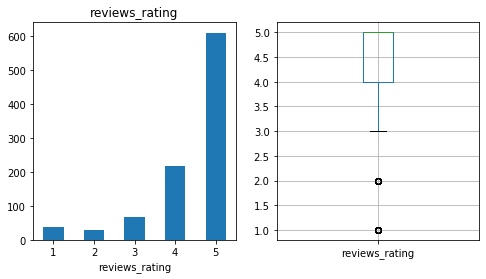

In [1596]:
# distribution of the rating variable
fig, axes = plt.subplots(1,2, figsize=(8,4))
amazon_hdf2.cols['reviews_rating'].hist(ax=axes[0])
amazon_hdf2.cols['reviews_rating'].boxplot(ax=axes[1])
plt.show()

###  toPandas 
used to investigate and plot categorical variables.

In [1597]:
amazon_pd = amazon.toPandas()
amazon_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1597 entries, 0 to 1596
Data columns (total 6 columns):
id                  1597 non-null object
dateadded           1597 non-null object
name                1597 non-null object
reviews_date        1217 non-null object
reviews_rating      1177 non-null float64
reviews_username    1580 non-null object
dtypes: float64(1), object(5)
memory usage: 75.0+ KB


### Missing values
can inhibit plotting.

In [1598]:
amazon_pd.isna().sum()

id                    0
dateadded             0
name                  0
reviews_date        380
reviews_rating      420
reviews_username     17
dtype: int64

In [1599]:
amazon_pd['reviews_rating'] = \
amazon_pd['reviews_rating'].fillna(amazon_pd['reviews_rating'].median())

In [1600]:
amazon_pd['reviews_date'] = \
amazon_pd['reviews_date'].fillna(method='ffill')


In [1601]:
amazon_na = amazon_pd.loc[amazon_pd['reviews_username'].isna(), 
                         ['reviews_rating','reviews_username']]

list22 = amazon_na.index.tolist()
amazon_2 = amazon_pd.drop(list22)
amazon_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1580 entries, 0 to 1596
Data columns (total 6 columns):
id                  1580 non-null object
dateadded           1580 non-null object
name                1580 non-null object
reviews_date        1580 non-null object
reviews_rating      1580 non-null float64
reviews_username    1580 non-null object
dtypes: float64(1), object(5)
memory usage: 86.4+ KB


In [1602]:
amazon_pd['reviews_username'] = \
amazon_pd['reviews_username'].dropna()

In [1603]:
amazon_pd.isna().sum()

id                   0
dateadded            0
name                 0
reviews_date         0
reviews_rating       0
reviews_username    17
dtype: int64

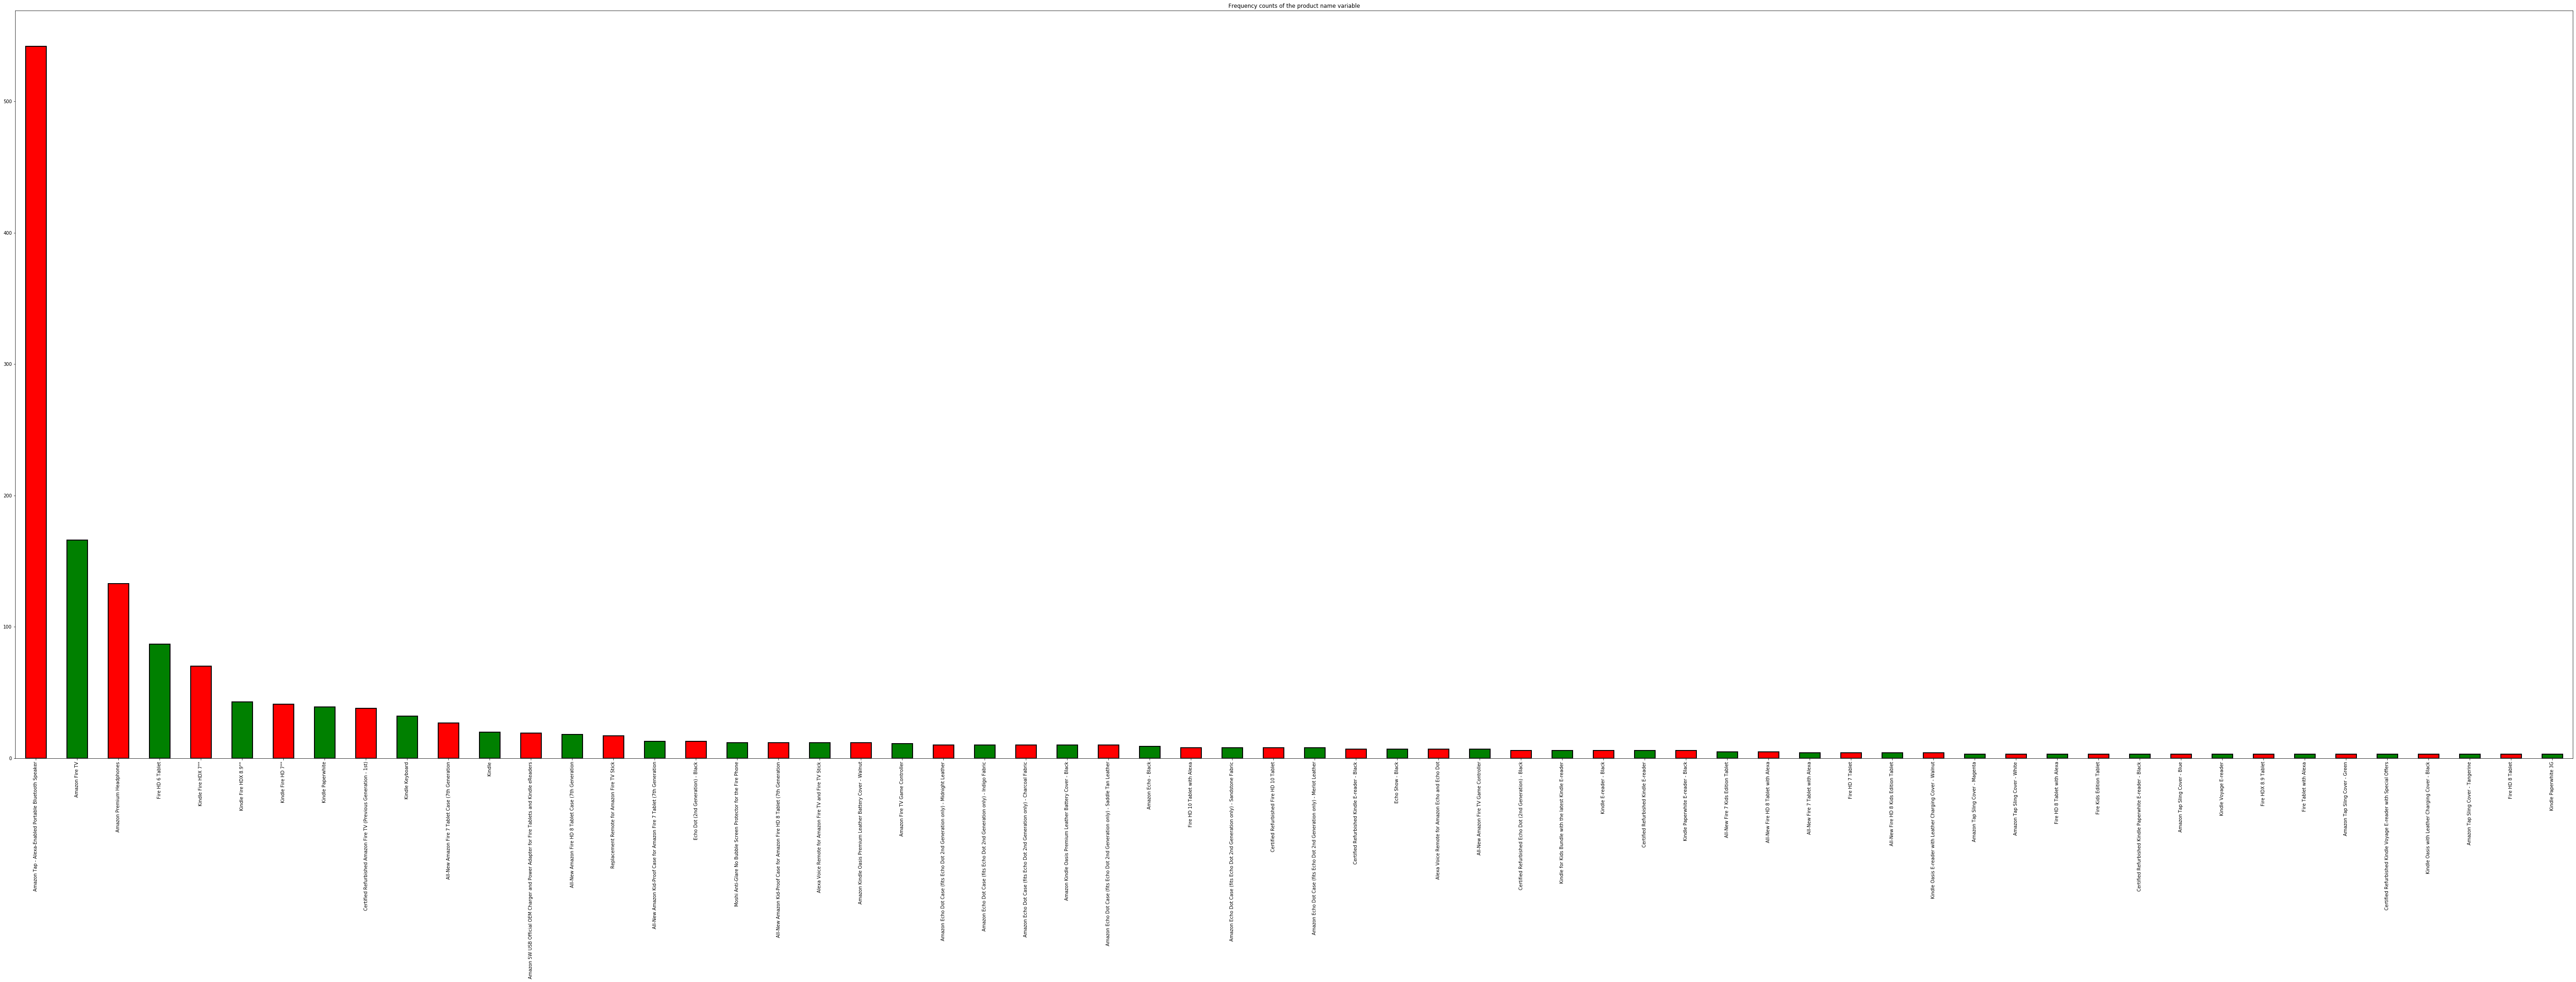

In [1604]:
amazon_pd['name'].value_counts().plot.bar(figsize=(100,30), 
                                          color=["red", "green"],
                                          edgecolor="black", linewidth=2,
                                          title='Frequency counts of the product name variable')
plt.show()

Interestingly the count of (product) names shows a long tail
to the right. The first 8 product names have the highest frequency.
This is not untypically and in line with the Pareto-distribution.

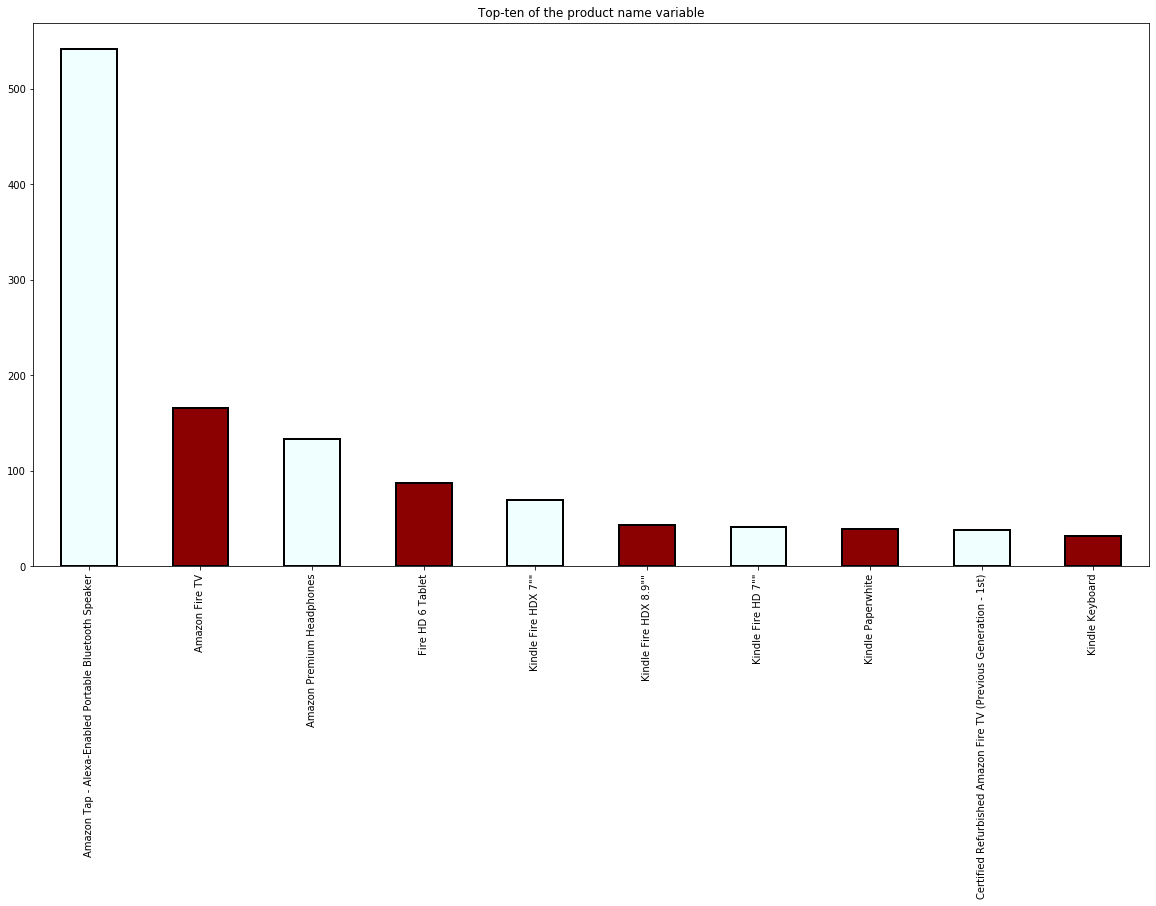

In [1605]:
amazon_pd['name'].value_counts()[:10].plot.bar(figsize=(20,10), 
                                          color=["azure", "darkred"],
                                          edgecolor="black", linewidth=2,
                                          title='Top-ten of the product name variable')
plt.show()

In [1606]:
print(amazon_pd['reviews_username'].unique()[:5])

usernames = amazon_pd['reviews_username'].value_counts()[:10]

print(usernames[:10] )

print("")

print(type(usernames))
print(usernames.describe())

print("")

usernames_index = usernames.index.tolist()
print(usernames_index[:5])

['Cristina M' 'Ricky' 'Tedd Gardiner' 'Dougal' 'Miljan David Tanic']
A. Younan          59
William Hardin     58
Andrew             43
Victor L.          30
NF                 29
Mike W.            29
Earthling1984      28
Amazon Reviewer    27
Mandy              26
Amazon Customer    22
Name: reviews_username, dtype: int64

<class 'pandas.core.series.Series'>
count    10.000000
mean     35.100000
std      13.453211
min      22.000000
25%      27.250000
50%      29.000000
75%      39.750000
max      59.000000
Name: reviews_username, dtype: float64

['A. Younan', 'William Hardin', 'Andrew', 'Victor L.', 'NF']


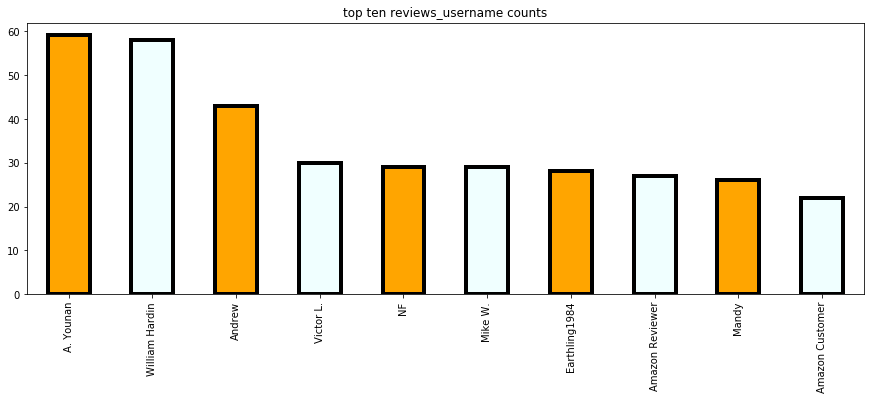

In [1607]:
usernames.plot.bar(x=usernames.index,
                   figsize=(15,5), color=["orange", "azure"], 
                   edgecolor="black", linewidth=4,
                   title="top ten reviews_username counts")

# plt.xticks(positions1, usernames_index)
plt.show()

### Datetime

There are two variables formatted as string objects, which are dates.
The string are converted into dates.

In [1608]:
print(amazon_pd['dateadded'][:3])
print(type(amazon_pd['dateadded'][5]))
print("")
print(amazon_pd['reviews_date'][:5])


0    2016-03-08T20:21:53Z
1    2016-03-08T20:21:53Z
2    2016-03-08T20:21:53Z
Name: dateadded, dtype: object
<class 'str'>

0    2015-08-08T00:00:00Z
1    2015-09-01T00:00:00Z
2    2015-07-20T00:00:00Z
3    2017-06-16T00:00:00Z
4    2016-08-11T00:00:00Z
Name: reviews_date, dtype: object


<p>How does datetime.strptime works?</p> 

<p>
It converts strings to dates and needs therefore a date in a 
string format. It takes a format, which describes the string 
format. The opposite is strftime. This converts a date to a string.
</p> 


<a href="https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior" target="_blank">strftime() and strptime() Behavior</a> 

In [1609]:
# from datetime import datetime
datetime_object =\
datetime.strptime('2015-10-30T08:59:32Z',"%Y-%m-%dT%H:%M:%SZ")
print(datetime_object)

2015-10-30 08:59:32


In [1610]:
# strptime converts a single value
# a (lambda) function looping over the column is therefore needed
# converting every row from string to datetime
amazon_pd['datetime_added'] =\
amazon_pd['dateadded'].apply(lambda x: 
                             datetime.strptime(x, "%Y-%m-%dT%H:%M:%SZ"))

print(amazon_pd['datetime_added'][:5])


0   2016-03-08 20:21:53
1   2016-03-08 20:21:53
2   2016-03-08 20:21:53
3   2016-03-08 20:21:53
4   2016-03-08 20:21:53
Name: datetime_added, dtype: datetime64[ns]


In [1611]:
amazon_pd['datetime_reviews'] =\
amazon_pd['reviews_date'].apply(lambda z: 
                                datetime.strptime(z, "%Y-%m-%dT%H:%M:%SZ"))

In [1612]:
print(amazon_pd.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1597 entries, 0 to 1596
Data columns (total 8 columns):
id                  1597 non-null object
dateadded           1597 non-null object
name                1597 non-null object
reviews_date        1597 non-null object
reviews_rating      1597 non-null float64
reviews_username    1580 non-null object
datetime_added      1597 non-null datetime64[ns]
datetime_reviews    1597 non-null datetime64[ns]
dtypes: datetime64[ns](2), float64(1), object(5)
memory usage: 99.9+ KB
None


In [1613]:
amazon_pd_2 = \
amazon_pd.drop_duplicates(subset=['datetime_added'], 
                          keep='first', inplace=False)

amazon_pd_2 = amazon_pd_2.sort_values(by='datetime_added')

amazon_pd_3 = \
amazon_pd.drop_duplicates(subset=['datetime_reviews'], 
                          keep='first', inplace=False)

amazon_pd_3 = amazon_pd_3.sort_values(by='datetime_reviews')

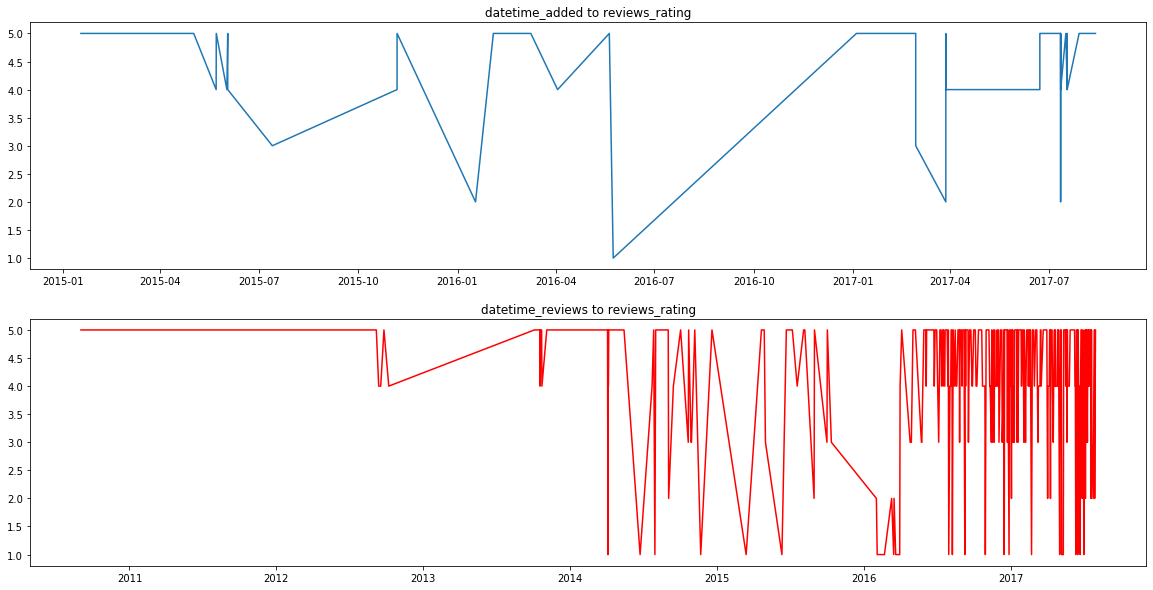

In [1614]:
# this plotting does not make much sense
# keep it here to remember this for heuristic reasons
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(20,10))
ax1.plot(amazon_pd_2.datetime_added, amazon_pd_2.reviews_rating)
ax1.set_title("datetime_added to reviews_rating")
ax2.plot(amazon_pd_3.datetime_reviews, amazon_pd_3.reviews_rating, color="red")
ax2.set_title("datetime_reviews to reviews_rating")
plt.show()

### Label encoding with Pandas

<p>
As shown above all columns besides review ratings are not numeric columns.
The goal of this project is to develop collaborative filtering models 
applying the Alternating Least Squares (ALS) algorithm. 
As most machine learning algorithms the ALS does only work with
numeric data and not strings. Therefore the strings are transformed
below into numeric data using label encoding. The labels work purely
as identifiers and indicating not any order. Besides reviews rating, 
it has got an ordinal relationship.
</p> 

<p>
Of course ideally this should also done in pyspark 
and pyspark offers some approaches, but not as mature
as the methods of sklearn and pandas. Therefore the detour
around this packages is done to do the label encoding.
</p> 

In [1615]:
# from sklearn import preprocessing
amazon_pandas_direct = pd.read_csv("amazon_query_3.csv")
print(amazon_pandas_direct.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1597 entries, 0 to 1596
Data columns (total 6 columns):
id                  1597 non-null object
dateadded           1597 non-null object
name                1597 non-null object
reviews_date        1217 non-null object
reviews_rating      1177 non-null float64
reviews_username    1580 non-null object
dtypes: float64(1), object(5)
memory usage: 75.0+ KB
None


In [1616]:
print(amazon_pandas_direct.reviews_rating.unique())

[ 5.  4. nan  3.  2.  1.]


#### Missing values

In [1617]:
amazon_pandas_direct.isnull().sum()
amazon_pandas_direct2 = amazon_pandas_direct.drop(labels=['reviews_date', 'dateadded'], axis=1)
amazon_pandas_direct2['reviews_rating'] = \
                      amazon_pandas_direct2['reviews_rating'].fillna(amazon_pandas_direct2['reviews_rating'].median())
amazon_pandas_direct2 = amazon_pandas_direct2.dropna()
amazon_pandas_direct2.info()
amazon_pandas_direct2.head()
amazon_pandas_direct2.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1580 entries, 0 to 1596
Data columns (total 4 columns):
id                  1580 non-null object
name                1580 non-null object
reviews_rating      1580 non-null float64
reviews_username    1580 non-null object
dtypes: float64(1), object(3)
memory usage: 61.7+ KB


id                  0
name                0
reviews_rating      0
reviews_username    0
dtype: int64

In [1618]:
print(amazon_pandas_direct2.reviews_rating.unique())

[5. 4. 3. 2. 1.]


In [1619]:
le = preprocessing.LabelEncoder()
le.fit(amazon_pandas_direct2['id'])
amazon_pandas_direct2['id'] = le.transform(amazon_pandas_direct2['id'])
print(amazon_pandas_direct2.head())
print(amazon_pandas_direct2['id'].unique())

   id               name  reviews_rating    reviews_username
0  33  Kindle Paperwhite             5.0          Cristina M
1  33  Kindle Paperwhite             5.0               Ricky
2  33  Kindle Paperwhite             4.0       Tedd Gardiner
3  33  Kindle Paperwhite             5.0              Dougal
4  33  Kindle Paperwhite             5.0  Miljan David Tanic
[33 37 40 44  1  6 30  3 24  7  5  9 48 10 11 45 29 31 49 27  0 19 13 15
  2  8 28 12 16 26 14  4 41 17 38 58 61 32 59 23 64 20 52 63 62 22 18 54
 60 21 35 36 25 57 56 53 51 34 43 50 55 46 65 47 39 42]


In [1620]:
cols140 = amazon_pandas_direct2.columns.tolist()
print(cols140)
cols140.remove('reviews_rating')
cols140.remove('id')
print(cols140)

['id', 'name', 'reviews_rating', 'reviews_username']
['name', 'reviews_username']


In [1621]:
le = preprocessing.LabelEncoder()
for i in cols140:
    print(i)
    print(type(i))
    le.fit(amazon_pandas_direct2[i])
    amazon_pandas_direct2[i] = le.transform(amazon_pandas_direct2[i])
    
print(amazon_pandas_direct2.head())
print(len(amazon_pandas_direct2.reviews_username.unique()))
print(np.count_nonzero(amazon_pandas_direct2.name.unique()))
print(amazon_pandas_direct2.shape)

name
<class 'str'>
reviews_username
<class 'str'>
   id  name  reviews_rating  reviews_username
0  33    55             5.0               151
1  33    55             5.0               618
2  33    55             4.0               722
3  33    55             5.0               215
4  33    55             5.0               525
949
61
(1580, 4)


In [1622]:
print(amazon_pandas_direct2.id.unique())

[33 37 40 44  1  6 30  3 24  7  5  9 48 10 11 45 29 31 49 27  0 19 13 15
  2  8 28 12 16 26 14  4 41 17 38 58 61 32 59 23 64 20 52 63 62 22 18 54
 60 21 35 36 25 57 56 53 51 34 43 50 55 46 65 47 39 42]


### Write cleaned data frame to disc as csv

In [1623]:
amazon_pandas_direct2.to_csv("amazon_pandas_cleaned.csv", sep=",", 
                             header=True, index=True, 
                             index_label="index_label")

In [1624]:
# check it
amazon_pandas_cleaned = pd.read_csv("amazon_pandas_cleaned.csv", sep=",")
print(amazon_pandas_cleaned.info())
print(amazon_pandas_cleaned.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1580 entries, 0 to 1579
Data columns (total 5 columns):
index_label         1580 non-null int64
id                  1580 non-null int64
name                1580 non-null int64
reviews_rating      1580 non-null float64
reviews_username    1580 non-null int64
dtypes: float64(1), int64(4)
memory usage: 61.8 KB
None
   index_label  id  name  reviews_rating  reviews_username
0            0  33    55             5.0               151
1            1  33    55             5.0               618
2            2  33    55             4.0               722
3            3  33    55             5.0               215
4            4  33    55             5.0               525


### Converting a pandas data frame into a pyspark data frame

In [1625]:
amazon_schema = \
StructType([    
    
    StructField('id', IntegerType(), True),
    StructField('name', IntegerType(), True),
    StructField('reviews_rating', FloatType(), True), 
    StructField('reviews_username', IntegerType(), True)

])

In [1626]:
amazon_sparkdf = spark.createDataFrame(amazon_pandas_direct2,
                                       schema=amazon_schema)


### Partions

In [1627]:
# current number of partitions
print(amazon_sparkdf.rdd.getNumPartitions())

# increase number of partitions
amazon_sparkdf_2 = amazon_sparkdf.repartition(30)

print(type(amazon_sparkdf_2))
print(amazon_sparkdf_2.rdd.getNumPartitions())

4
<class 'pyspark.sql.dataframe.DataFrame'>
30


### Explore the newly created pyspark data frame

In [1628]:
print(type(amazon_sparkdf_2))
print(amazon_sparkdf_2.count())
print(amazon_sparkdf_2.printSchema())

<class 'pyspark.sql.dataframe.DataFrame'>
1580
root
 |-- id: integer (nullable = true)
 |-- name: integer (nullable = true)
 |-- reviews_rating: float (nullable = true)
 |-- reviews_username: integer (nullable = true)

None


In [1629]:
# drop id column because it is not necessary for analysing
amazon_sparkdf_2 = amazon_sparkdf_2.drop('id')

print(type(amazon_sparkdf_2))
print(amazon_sparkdf_2.show(5))

<class 'pyspark.sql.dataframe.DataFrame'>
+----+--------------+----------------+
|name|reviews_rating|reviews_username|
+----+--------------+----------------+
|  34|           5.0|              70|
|  30|           5.0|             489|
|  30|           5.0|             772|
|  45|           4.0|             138|
|  19|           5.0|             279|
+----+--------------+----------------+
only showing top 5 rows

None


### Does pyspark operations work?

In [1630]:
print(amazon_sparkdf_2.show(5))

+----+--------------+----------------+
|name|reviews_rating|reviews_username|
+----+--------------+----------------+
|  34|           5.0|              70|
|  30|           5.0|             489|
|  30|           5.0|             772|
|  45|           4.0|             138|
|  19|           5.0|             279|
+----+--------------+----------------+
only showing top 5 rows

None


In [1631]:
amazon_sparkdf_2.where(col('reviews_rating') == 5).show(3)

+----+--------------+----------------+
|name|reviews_rating|reviews_username|
+----+--------------+----------------+
|  30|           5.0|             298|
|  19|           5.0|             468|
|  55|           5.0|             151|
+----+--------------+----------------+
only showing top 3 rows



In [1632]:
# from pyspark.sql.functions import *
# sum does not make much sense
amazon_sparkdf_2.groupby("reviews_rating").sum().show()

+--------------+---------+-------------------+---------------------+
|reviews_rating|sum(name)|sum(reviews_rating)|sum(reviews_username)|
+--------------+---------+-------------------+---------------------+
|           5.0|    33142|             5720.0|               495967|
|           2.0|      693|               68.0|                15147|
|           3.0|     3279|              372.0|                41165|
|           1.0|     1192|               42.0|                17102|
|           4.0|     6285|              944.0|               105885|
+--------------+---------+-------------------+---------------------+



### Load the cleaned data frame and conduct operations

In [1633]:
amazon_schema_2 = \
StructType([    
    
    StructField('index_label', IntegerType(), True),
    StructField('id', IntegerType(), True),
    StructField('name', IntegerType(), True),
    StructField('reviews_rating', FloatType(), True), 
    StructField('reviews_username', IntegerType(), True)

])


amazon_cleaned = \
spark.read.csv("amazon_pandas_cleaned_2.csv", 
               inferSchema=True, 
               header=True,
               sep=",",
               schema=amazon_schema_2)

amazon_cleaned = amazon_cleaned.drop(*['index_label', 'id'])

print(type(amazon_cleaned))
print("")
print(amazon_cleaned.columns)
amazon_schema_2 = \
StructType([    
    
    StructField('index_label', IntegerType(), True),
    StructField('id', IntegerType(), True),
    StructField('name', IntegerType(), True),
    StructField('reviews_rating', FloatType(), True), 
    StructField('reviews_username', IntegerType(), True)

])

amazon_cleaned = \
spark.read.csv("amazon_pandas_cleaned_2.csv", 
               inferSchema=True, 
               header=True,
               sep=",",
               schema=amazon_schema_2)

amazon_cleaned = amazon_cleaned.drop(*['index_label', 'id'])



<class 'pyspark.sql.dataframe.DataFrame'>

['name', 'reviews_rating', 'reviews_username']


In [1634]:
print(sc.defaultMinPartitions)

amazon_rdd_part = amazon_rdd.repartition(50)

print(type(amazon_rdd_part))
print(amazon_rdd_part.getNumPartitions())

2
<class 'pyspark.rdd.RDD'>
50


### Explore data frame

In [1635]:
print(type(amazon_cleaned))
print("")
print(amazon_cleaned.columns)
print(amazon_cleaned.take(5))
print("")
print(amazon_cleaned.show(4))
print("")
print(amazon_cleaned.printSchema())

print(amazon_cleaned.take(5))
print("")
print(amazon_cleaned.show(4))
print("")
print(amazon_cleaned.printSchema())


<class 'pyspark.sql.dataframe.DataFrame'>

['name', 'reviews_rating', 'reviews_username']
[Row(name=55, reviews_rating=5.0, reviews_username=151), Row(name=55, reviews_rating=5.0, reviews_username=618), Row(name=55, reviews_rating=4.0, reviews_username=722), Row(name=55, reviews_rating=5.0, reviews_username=215), Row(name=55, reviews_rating=5.0, reviews_username=525)]

+----+--------------+----------------+
|name|reviews_rating|reviews_username|
+----+--------------+----------------+
|  55|           5.0|             151|
|  55|           5.0|             618|
|  55|           4.0|             722|
|  55|           5.0|             215|
+----+--------------+----------------+
only showing top 4 rows

None

root
 |-- name: integer (nullable = true)
 |-- reviews_rating: float (nullable = true)
 |-- reviews_username: integer (nullable = true)

None
[Row(name=55, reviews_rating=5.0, reviews_username=151), Row(name=55, reviews_rating=5.0, reviews_username=618), Row(name=55, reviews_rating=4.

#### Does operations work on this data frame?

In [1636]:
# only mean of reviews rating makes sense
# it has an ordinal relationship
# as the other are purely identifiers
amazon_cleaned.describe().show()

+-------+-----------------+------------------+------------------+
|summary|             name|    reviews_rating|  reviews_username|
+-------+-----------------+------------------+------------------+
|  count|             1580|              1580|              1580|
|   mean|28.22215189873418| 4.522784810126582|427.38354430379746|
| stddev|13.92536481054414|0.9247082441602237| 281.2931929506109|
|    min|                0|               1.0|                 0|
|    max|               61|               5.0|               948|
+-------+-----------------+------------------+------------------+



In [1637]:
amazon_cleaned.describe('reviews_rating').show()

+-------+------------------+
|summary|    reviews_rating|
+-------+------------------+
|  count|              1580|
|   mean| 4.522784810126582|
| stddev|0.9247082441602237|
|    min|               1.0|
|    max|               5.0|
+-------+------------------+



In [1638]:
amazon_cleaned.where(col('reviews_rating') == 5).show(3)

+----+--------------+----------------+
|name|reviews_rating|reviews_username|
+----+--------------+----------------+
|  55|           5.0|             151|
|  55|           5.0|             618|
|  55|           5.0|             215|
+----+--------------+----------------+
only showing top 3 rows



In [1639]:
# from pyspark.sql.functions import *
# sum does not make much sense
amazon_cleaned.select('reviews_rating').\
groupby("reviews_rating").count().show()

+--------------+-----+
|reviews_rating|count|
+--------------+-----+
|           5.0| 1144|
|           4.0|  236|
|           3.0|  124|
|           2.0|   34|
|           1.0|   42|
+--------------+-----+



In [1640]:
# this confirms the groupby from above
amazon_cleaned.filter(amazon_cleaned.reviews_rating >4).count()

1144

In [1641]:
# top ten producty by rating
amazon_cleaned.groupby('name').\
agg({'reviews_rating': 'mean'}).\
orderBy('avg(reviews_rating)').show(10)
# 2 and 22 have the best average rating

+----+-------------------+
|name|avg(reviews_rating)|
+----+-------------------+
|   1| 2.0833333333333335|
|  61| 2.5294117647058822|
|  45| 2.6666666666666665|
|  60| 3.3333333333333335|
|   0| 3.4285714285714284|
|   3| 3.5555555555555554|
|  34| 3.5714285714285716|
|  42| 3.6666666666666665|
|  22| 3.6666666666666665|
|   2| 3.7777777777777777|
+----+-------------------+
only showing top 10 rows



In [1642]:
# there are 62 distinct products
print(amazon_cleaned.select('name').distinct().count())

# there are 949 distinct reviewers
print(amazon_cleaned.select('reviews_username').distinct().count())


62
949


The operations work. This indicates the data frame is intact.

### Get the RDD underlying data frame

<p>Pyspark data frames are resilient distributed data structures
and grounded on RDDs. This other than the Pandas data frames,
which are in-memory locally on a single machine. (Of course
the cluster here is for practical reasons also locally 
but can be easily distributed on many machines.</p> 

In [1643]:
amazon_cleaned_rdd_144 = amazon_cleaned.rdd
print(amazon_cleaned_rdd_144.take(3))
print(amazon_cleaned_rdd_144.countByKey())

[Row(name=55, reviews_rating=5.0, reviews_username=151), Row(name=55, reviews_rating=5.0, reviews_username=618), Row(name=55, reviews_rating=4.0, reviews_username=722)]
defaultdict(<class 'int'>, {55: 39, 52: 32, 30: 38, 51: 43, 17: 10, 25: 3, 18: 8, 4: 7, 41: 4, 20: 11, 29: 3, 27: 3, 33: 6, 26: 3, 57: 6, 56: 3, 39: 8, 15: 8, 45: 3, 38: 7, 32: 8, 34: 7, 58: 3, 14: 10, 28: 3, 35: 3, 54: 3, 44: 3, 53: 4, 48: 6, 36: 3, 31: 6, 19: 166, 11: 19, 2: 27, 47: 20, 3: 18, 42: 3, 5: 13, 10: 5, 40: 87, 16: 10, 6: 12, 43: 3, 9: 4, 59: 6, 13: 10, 7: 5, 49: 41, 8: 4, 37: 13, 46: 3, 12: 9, 50: 53, 24: 542, 60: 12, 0: 7, 22: 12, 21: 10, 23: 133, 61: 17, 1: 12})


### Partions

<p>are costly , but more partitions may make the 
the execution smoother.</p> 

In [1644]:
print(sc.defaultMinPartitions)

amazon_cleaned_rdd = amazon_cleaned_rdd_144.repartition(50)

print(type(amazon_cleaned_rdd))
print(amazon_cleaned_rdd.getNumPartitions())

2
<class 'pyspark.rdd.RDD'>
50


### Machine Learning: Alternating Least Squares (ALS)

<p>
is an algorithm widely used for collaborative filtering.
The aim is to find users with common interests (products, clubs, activities ...).
Recommendations are based on the “birds of a feather flock together”-assumption that people who share an opinion on one topic are more likely to share again an opinion on another new independent topic than with a random third person.</p> 
<p>
This assumption is plausible and is strong in people of one subculture
like <a href="https://en.wikipedia.org/wiki/Emo" target="_blank">Emo</a> for example. Emo adherents are going to listen probably to similar music listened by other EMO-adherents. The assumption is then used to recommend something (music, products) to people, who are likely to share an opinion. Data sets with ratings on topics (good, bad music) are
excellent for collaborative filtering. The two main types are:
</p>

<ul>
<li>User-to-user: find users similar to the target user and recommends the user
to the target user like in dating matchmaking.</li>
<li>Item-to-item: items (science fiction books) of the target users are used to find similar
items of user users and recommended to the target user.</li>
</ul> 

<a href="https://en.wikipedia.org/wiki/Collaborative_filtering" target="_blank">Wikipedia</a> 

In [1645]:
# from pyspark.mllib.recommendation import Rating
# keep only 'reviews_username', 'name', 'reviews_rating' in the model by using column index
# amazon_split = amazon_cleaned.rdd.map(lambda l: l.split(','))
# is not necessary because the data is allready split
# this took me some hours to understand :-(

amazon_features = \
amazon_cleaned.rdd.map(lambda row: Rating(int(row[2]), 
                                      int(row[0]), float(row[1])))

print(type(amazon_features))
print(amazon_features.take(5))
print(amazon_features.count())

<class 'pyspark.rdd.PipelinedRDD'>
[Rating(user=151, product=55, rating=5.0), Rating(user=618, product=55, rating=5.0), Rating(user=722, product=55, rating=4.0), Rating(user=215, product=55, rating=5.0), Rating(user=525, product=55, rating=5.0)]
1580


### Create traning and test data

In [1646]:
az_training_data, az_test_data = amazon_features.randomSplit([0.8, 0.2])

print(type(training_data))
print(training_data.take(3))

<class 'pyspark.rdd.PipelinedRDD'>
[Rating(user=151, product=55, rating=5.0), Rating(user=618, product=55, rating=5.0), Rating(user=722, product=55, rating=4.0)]


#### Build the model

In [1647]:
az_model = ALS.train(az_training_data, rank=10, iterations=10)
print(type(az_model))

<class 'pyspark.mllib.recommendation.MatrixFactorizationModel'>


<p>
This has created a MatrixFactorizationModel.
"A matrix factorisation model trained by regularized alternating least-squares." <a href="https://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.recommendation.ALS" target="_blank">pyspark.mllib.recommendation module</a>     
</p> 


<p>
"Matrix factorization algorithms work by decomposing the user-item interaction matrix into the product of two lower dimensionality rectangular matrices." <a href="https://en.wikipedia.org/wiki/Matrix_factorization_(recommender_systems)" target="_blank">Wikipedia</a> 
</p>

<p>
<img src="colla_matrix.png" alt="Smiley face" height="250" width="250" align="left"> 
</p> 


In [1648]:
# test data without rating
# rating is the third element in the subslists
az_test_data_2 = az_test_data.map(lambda p: (p[0], p[1]))
print(type(az_test_data_2))
print(az_test_data_2.take(5))

<class 'pyspark.rdd.PipelinedRDD'>
[(215, 55), (67, 55), (722, 55), (516, 55), (485, 55)]


### Predictions

In [1649]:
# from pyspark.mllib.recommendation import ALS
az_predict_ALS = ALS_model.predictAll(az_test_data_2)
print(type(az_predict_ALS ))
print(az_predict_ALS.take(4))
# Rating(user=151, product=55, rating=5.0)

<class 'pyspark.rdd.RDD'>
[Rating(user=228, product=5, rating=1.6708327712292408), Rating(user=160, product=59, rating=2.8391087035836406), Rating(user=512, product=41, rating=5.0553072492379085), Rating(user=512, product=50, rating=4.163189203309809)]


### Model evaluation
with Mean Square Error (MSE)

In [1650]:
# Prepare ratings data
# make a tuple of ((user, product), rating))
# (r[0], r[1]) is enclosed as one tuple
# r[2] is the rating
az_ratings = amazon_features.map(lambda row: ((row[0], row[1]), row[2]))

print(type(az_ratings))
print(az_ratings.count())
print(az_ratings.take(10))
# Rating(user=151, product=55, rating=5.0)

<class 'pyspark.rdd.PipelinedRDD'>
1580
[((151, 55), 5.0), ((618, 55), 5.0), ((722, 55), 4.0), ((215, 55), 5.0), ((525, 55), 5.0), ((410, 55), 5.0), ((618, 55), 5.0), ((67, 55), 5.0), ((151, 55), 5.0), ((722, 55), 5.0)]


In [1651]:
az_predictions_ALS_2 = \
az_predict_ALS.map(lambda row: ((row[0], row[1]), row[2]))

print(type(az_predictions_ALS_2 ))
print(az_predictions_ALS_2.count())
print(az_predictions_ALS_2.take(10))

<class 'pyspark.rdd.PipelinedRDD'>
213
[((228, 5), 1.6708327712292408), ((160, 59), 2.8391087035836406), ((512, 41), 5.0553072492379085), ((512, 50), 4.163189203309809), ((332, 13), 3.197069868597138), ((112, 6), 3.083635576714171), ((420, 6), 5.163786035431643), ((300, 24), 4.989249822352054), ((184, 50), 5.076135219420555), ((632, 52), 3.6648165915944086)]


In [1652]:
az_predict_observe = az_ratings.join(az_predictions_ALS_2)

print(type(az_predict_observe))
print(az_predict_observe.take(5))
print(az_predict_observe.count())

<class 'pyspark.rdd.PipelinedRDD'>
[((215, 55), (5.0, 1.836165650806469)), ((516, 55), (5.0, 2.129299764938258)), ((157, 52), (5.0, 3.391673885894876)), ((512, 41), (5.0, 5.0553072492379085)), ((239, 20), (5.0, 2.444606221585733))]
1407


The observed values are the first elements in the second tuples.
The predicted values are the second elements in the second tuples.
Observed and predicted values are needed for the MSE.

#### Understanding the joined RDDs:

joined RDDs: ((115, 19), (4.0, 2.4111713656380083)): a row consists of two tuples within one higher tuple<br>
observed ratings: r[1][0] = (4.0) = first tuple, first element of row<br>
predicted ratings: r[1][1] = (2.4111713656380083) = first tuple, second element of row

In [1653]:
# MSE: mean squared error
MSE_az = az_predict_observe.map(lambda r: (r[1][0] - r[1][1])**2).mean()
print("MSE_az - test  = {:.5f}".format(MSE_az))


MSE_az - test  = 2.80020


In [1654]:
RootMSE_az = np.sqrt(MSE_az)
print("RootMSE_az - test  = {:.5f}".format(RootMSE_az))

RootMSE_az - test  = 1.67338


### Applying  recommendation methods based on the MatrixFactorizationModel

<p>, a matrix factorisation model trained by regularized alternating 
least-squares. The explanations are taken from the documentation.</p> 
<a href="https://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.recommendation.ALS" target="_blank">
pyspark.mllib package</a> 
<p>The methods are resulting in recommendations for products and
users or clarify the relationship between both.</p> 

In [1655]:
# from pyspark.mllib.recommendation import MatrixFactorizationModel
# Save and load model
# az_model.save(sc, "amazon_CollaborativeFilter")


In [1656]:
# load the MatrixFactorizationModel from disc
model_factor_az = \
MatrixFactorizationModel.load(sc, "amazon_CollaborativeFilter")

print(model_factorized)

#### Predicts rating for a given user and product

In [1657]:
# predict(user, product)
print(model_factor_az.predict(151, 55))
print(model_factor_az.predict(189, 4))
print(model_factor_az.predict(199, 27))
print(model_factor_az.predict(337, 41))

4.998983703732036
2.9979585995232982
5.000213969202477
4.995763093459676


#### productFeatures() 
returns a paired RDD, where the first element 
is the product and the second is an array of features corresponding 
to that product.

In [1658]:
az_productFeatures = model_factor_az.productFeatures()

print(az_productFeatures)
print(type(az_productFeatures))

# lazy evaluation
# the RDD is not executed 
# untill it is called with RDD-domain specific language
print(az_productFeatures.take(1))
print("")

# create a data frame
az_productFeatures_rdd = sqlContext.createDataFrame(az_productFeatures)
az_productFeatures_rdd.show(5)

PythonRDD[10336] at RDD at PythonRDD.scala:53
<class 'pyspark.rdd.PipelinedRDD'>
[(1, array('d', [-0.7492132782936096, 0.5889517068862915, 2.4385461807250977, -0.27534055709838867, 3.2937707901000977, 0.1900889277458191, -0.2477518916130066, 0.3438398540019989, 0.2170984148979187, 1.3532295227050781]))]

+---+--------------------+
| _1|                  _2|
+---+--------------------+
|  1|[-0.7492132782936...|
|  5|[-3.2143046855926...|
|  9|[-1.2085622549057...|
| 13|[-2.3477382659912...|
| 17|[-2.3348147869110...|
+---+--------------------+
only showing top 5 rows



#### Rank 
for the features in this model.

In [1659]:
model_factor_az.rank

10

#### recommendProducts(user, num)

Recommends the top “num” number of products for a given user and returns 
a list of Rating objects sorted by the predicted rating in descending 
order. Very interesting method!

In [1660]:
model_factor_az.recommendProducts(151, 10)

[Rating(user=151, product=55, rating=4.998983703732036),
 Rating(user=151, product=41, rating=3.0886727559190623),
 Rating(user=151, product=36, rating=2.6350487794911586),
 Rating(user=151, product=53, rating=2.201333110695885),
 Rating(user=151, product=7, rating=2.1876447023739836),
 Rating(user=151, product=56, rating=2.1719924865693696),
 Rating(user=151, product=57, rating=2.1719924865693696),
 Rating(user=151, product=58, rating=2.1485576451809596),
 Rating(user=151, product=31, rating=2.139679002822483),
 Rating(user=151, product=35, rating=2.0634408632069077)]

#### recommendProductsForUsers(num)
Recommends the top “num” number of products for all users. 
The number of recommendations returned per user may be less than “num”.


In [1661]:
az_ProductsForUsers = model_factor_az.recommendProductsForUsers(5)

print(type(az_ProductsForUsers))
print(az_ProductsForUsers.count())
print(az_ProductsForUsers.take(1))

<class 'pyspark.rdd.RDD'>
782
[(784, (Rating(user=784, product=2, rating=4.998772134219841), Rating(user=784, product=53, rating=3.6954384357567096), Rating(user=784, product=3, rating=2.8224361798933018), Rating(user=784, product=5, rating=2.771749430136948), Rating(user=784, product=9, rating=2.4586953144096917)))]


#### recommendUsers(product, num)

Recommends the top “num” number of users for a given product 
and returns a list of Rating objects sorted by the predicted 
rating in descending order.

In [1662]:
az_recommendUsers = model_factor_az.recommendUsers(5, 5)

print(type(az_recommendUsers))
print(az_recommendUsers[:10])

<class 'list'>
[Rating(user=87, product=5, rating=6.38639662938143), Rating(user=107, product=5, rating=6.38639662938143), Rating(user=103, product=5, rating=6.38639662938143), Rating(user=71, product=5, rating=6.38639662938143), Rating(user=3, product=5, rating=6.38639662938143)]


#### userFeatures()

Returns a paired RDD, where the first element is the user and the second is an array of features corresponding to that user.

In [1663]:
az_userFeatures = model_factor_az.userFeatures()

print(az_userFeatures)
print(type(az_userFeatures))
print(az_userFeatures.count())
print(az_userFeatures.take(1))

PythonRDD[10367] at RDD at PythonRDD.scala:53
<class 'pyspark.rdd.PipelinedRDD'>
782
[(0, array('d', [-1.3431980609893799, -1.3617494106292725, 1.9264732599258423, 0.43271777033805847, 0.5598254203796387, 0.8303602337837219, -0.8580541610717773, 0.8065422773361206, -0.4410060942173004, 1.450345516204834]))]


# Movie rating data set

In [1664]:
movie_schema = \
StructType([
    StructField("userID", IntegerType(), True),
    StructField("movieID", IntegerType(), True),
    StructField("rating", FloatType(), True),
    StructField("timestamp", IntegerType(), True)
])

### Import with csv

In [1665]:
movie = \
spark.read.csv("movieratings.csv", 
               inferSchema=True, 
               header=False,
               schema=movie_schema)

In [1666]:
print(type(movie))
print("")
print(movie.columns)
print("")
print("shape: rows: {}, columns: {}".\
      format(movie.count(), len(movie.columns)))
print(movie.show(3))

<class 'pyspark.sql.dataframe.DataFrame'>

['userID', 'movieID', 'rating', 'timestamp']

shape: rows: 100004, columns: 4
+------+-------+------+----------+
|userID|movieID|rating| timestamp|
+------+-------+------+----------+
|     1|     31|   2.5|1260759144|
|     1|   1029|   3.0|1260759179|
|     1|   1061|   3.0|1260759182|
+------+-------+------+----------+
only showing top 3 rows

None


In [1667]:
print(movie.count(), len(movie.columns))

100004 4


### Import as text file

In [1668]:
movieratings_rdd=sc.textFile("movieratings.csv")
print(type(movieratings_rdd))
print(movieratings_rdd.take(5))
print(movieratings_rdd.count())

<class 'pyspark.rdd.RDD'>
['1,31,2.5,1260759144', '1,1029,3.0,1260759179', '1,1061,3.0,1260759182', '1,1129,2.0,1260759185', '1,1172,4.0,1260759205']
100004


### Data preparation: using the map() function

<p>
applies the input (built in, defined, lambda) function to each item of a given iterable
object like lists, tuples, pandas series and returns a map iterator.
</p> 

<p>
Double all numbers using map and lambda<br>  
numbers = (1, 2, 3, 4)<br>
result = map(lambda x: x + x, numbers)<br> 
print(list(result))<br>
{2, 4, 6, 8}

</p> 


<a href="https://www.geeksforgeeks.org/python-map-function/" target="_blank">Geeks</a> 

<p>
The Alternating Least Squares (ALS) does only need the three variables
user (reviews username), product (name) and rating (reviews_rating). 
</p> 


In [1669]:
movie_split = movieratings_rdd.map(lambda row: row.split(',') )
print(type(movie_split))
print(movie_split.take(3))

<class 'pyspark.rdd.PipelinedRDD'>
[['1', '31', '2.5', '1260759144'], ['1', '1029', '3.0', '1260759179'], ['1', '1061', '3.0', '1260759182']]


In [1670]:
# from pyspark.mllib.recommendation import Rating
# keep only 'userID', 'movieID', 'rating' in the model by using column index
movieratings2 = movie_split.map(lambda line: 
                                Rating(int(line[0]), int(line[1]), float(line[2])))
print(type(movieratings2))
print(movieratings2.take(3))


<class 'pyspark.rdd.PipelinedRDD'>
[Rating(user=1, product=31, rating=2.5), Rating(user=1, product=1029, rating=3.0), Rating(user=1, product=1061, rating=3.0)]


## Machine Learning

### Create traning and test data

In [1671]:
training, test = movieratings2.randomSplit([0.8, 0.2])


Check training data.

In [1672]:
print(training.take(2))
print(training.count())
print(training.count()/(training.count() + test.count()))

[Rating(user=1, product=31, rating=2.5), Rating(user=1, product=1029, rating=3.0)]
80089
0.8008579656813728


Check test data.

In [1673]:
print(test.take(2))
print(test.count())
print(test.count()/(training.count() + test.count()))

[Rating(user=1, product=1061, rating=3.0), Rating(user=2, product=10, rating=4.0)]
19915
0.19914203431862726


### Build and train the model

In [1674]:
ALS_model_movie = ALS.train(training, rank=10, iterations=10)
print(ALS_model_movie )

This has created a MatrixFactorizationModel.
"A matrix factorisation model trained by regularized alternating least-squares."

In [1675]:
# test data without rating
# rating is the third element in the subslists
test_2 = test.map(lambda p: (p[0], p[1]))
print(type(test_2))
print(test_2.take(2))

<class 'pyspark.rdd.PipelinedRDD'>
[(1, 1061), (2, 10)]


### Predictions

In [1676]:
predictions_ALS = ALS_model_movie.predictAll(test_2)
print(type(predictions_ALS ))
print(predictions_ALS.take(2))

<class 'pyspark.rdd.RDD'>
[Rating(user=96, product=1084, rating=4.312199885082958), Rating(user=336, product=1084, rating=0.8873966962563092)]


### Model evaluation
with Mean Square Error (MSE)

In [1677]:
# Prepare ratings data
# make a tuple of ((user, product), rating))
# (r[0], r[1]) is enclosed as one tuple
# r[2] is the rating
ratings_2 = movieratings2.map(lambda row: ((row[0], row[1]), row[2]))

print(type(ratings_2))
print(ratings_2.count())
print(ratings_2.take(10))

<class 'pyspark.rdd.PipelinedRDD'>
100004
[((1, 31), 2.5), ((1, 1029), 3.0), ((1, 1061), 3.0), ((1, 1129), 2.0), ((1, 1172), 4.0), ((1, 1263), 2.0), ((1, 1287), 2.0), ((1, 1293), 2.0), ((1, 1339), 3.5), ((1, 1343), 2.0)]


In [1678]:
predictions_ALS_2 = \
predictions_ALS.map(lambda row: ((row[0], row[1]), row[2]))

print(type(predictions_ALS_2))
print(predictions_ALS_2.count())
print(predictions_ALS_2.take(10))

<class 'pyspark.rdd.PipelinedRDD'>
19186
[((96, 1084), 4.312199885082958), ((336, 1084), 0.8873966962563092), ((468, 1084), 3.6153357894736415), ((580, 1084), 3.5031394935480726), ((65, 1084), 4.988291411073068), ((561, 1084), 3.0767459739544063), ((358, 1084), 5.312100156050451), ((19, 1084), 4.119091210791759), ((195, 1084), 3.6548405465756675), ((431, 1084), 4.516999618857749)]


In [1679]:
predict_observe = ratings_2.join(predictions_ALS_2)

print(type(predict_observe))
print(predict_observe.take(5))
print(predict_observe.count())

<class 'pyspark.rdd.PipelinedRDD'>
[((2, 10), (4.0, 3.938003923827254)), ((2, 616), (3.0, 3.009919624501458)), ((3, 247), (3.5, 4.642822112077839)), ((3, 44191), (3.5, 4.776063493329726)), ((4, 260), (5.0, 5.118191749456727))]
19186


#### Understanding the joined RDDs:
joined RDDs: ((2, 186), (3.0, 186)): a row consists of two tuples within one higher tuple<br>
observed ratings: r[1][0] = (2, 186) = first tuple, first sub tuple of row<br>
predicted ratings: r[1][1] = (3.0, 186) = first tuple, second sub tuple of row

In [1680]:
# MSE: mean squared error
MSE = predict_observe.map(lambda r: (r[1][0] - r[1][1])**2).mean()
print("MSE - test date = {:.5f}".format(MSE))
RSME = np.sqrt(MSE)
print("RSME - test date = {:.5f}".format(RSME))

MSE - test date = 1.38652
RSME - test date = 1.17751


### Applying  recommendation methods based on the MatrixFactorizationModel

In [1681]:
# save the model to disc
# ALS_model_movie.save(sc, "movies_CollaborativeFilter")

In [1682]:
model_factor_az = \
MatrixFactorizationModel.load(sc, "amazon_CollaborativeFilter")

print(model_factorized)

In [1683]:
model_factor_movie = \
MatrixFactorizationModel.load(sc, "movies_CollaborativeFilter")

print(model_factor_movie)

#### Predicts rating for a given user and product

In [1684]:
# predict(user, product)
print(model_factor_movie.predict(151, 55))
print(model_factor_movie.predict(189, 4))
print(model_factor_movie.predict(199, 27))
print(model_factor_movie.predict(337, 41))

-0.5305107055885454
2.9785154512825835
2.9610094627004186
1.5410390015943136


#### productFeatures() 
returns a paired RDD, where the first element 
is the product and the second is an array of features corresponding 
to that product.

In [1685]:
movie_productFeatures = model_factor_movie.productFeatures()

print(movie_productFeatures)
print(type(movie_productFeatures))

# lazy evaluation
# the RDD is not executed 
# untill it is called with RDD-domain specific language
print(movie_productFeatures.take(1))
print("")

# create a data frame
movie_productFeatures_rdd = sqlContext.createDataFrame(movie_productFeatures)
movie_productFeatures_rdd.show(5)

PythonRDD[10700] at RDD at PythonRDD.scala:53
<class 'pyspark.rdd.PipelinedRDD'>
[(4, array('d', [0.758673906326294, 0.41261497139930725, 1.2937519550323486, -0.4945254921913147, -1.0534710884094238, -0.5077402591705322, 0.15206055343151093, 1.8800853490829468, -1.7657924890518188, 0.2994782626628876]))]

+---+--------------------+
| _1|                  _2|
+---+--------------------+
|  4|[0.75867390632629...|
|  8|[0.62955826520919...|
| 12|[0.76855647563934...|
| 16|[-0.1294945776462...|
| 20|[-0.1549502015113...|
+---+--------------------+
only showing top 5 rows



#### Rank 
for the features in this model.

In [1686]:
model_factor_movie.rank

10

#### recommendProducts(user, num)

Recommends the top “num” number of products for a given user and returns 
a list of Rating objects sorted by the predicted rating in descending 
order. Very interesting method!

In [1687]:
model_factor_movie.recommendProducts(151, 10)

[Rating(user=151, product=6216, rating=8.780625843849302),
 Rating(user=151, product=67255, rating=8.263079469169764),
 Rating(user=151, product=2594, rating=8.207744009114792),
 Rating(user=151, product=241, rating=8.155969994234924),
 Rating(user=151, product=2068, rating=7.97340487251423),
 Rating(user=151, product=1303, rating=7.655566405781084),
 Rating(user=151, product=1298, rating=7.614474131749882),
 Rating(user=151, product=81229, rating=7.553176311106911),
 Rating(user=151, product=54328, rating=7.416590857971171),
 Rating(user=151, product=81932, rating=7.363462460560465)]

#### recommendProductsForUsers(num)
Recommends the top “num” number of products for all users. 
The number of recommendations returned per user may be less than “num”.


In [1688]:
movie_ProductsForUsers = model_factor_movie.recommendProductsForUsers(5)

print(type(movie_ProductsForUsers))
print(movie_ProductsForUsers.count())
print(movie_ProductsForUsers.take(1))

<class 'pyspark.rdd.RDD'>
671
[(224, (Rating(user=224, product=2356, rating=6.818201658432476), Rating(user=224, product=4914, rating=6.625582218729222), Rating(user=224, product=206, rating=6.568034085325149), Rating(user=224, product=1209, rating=6.470799745399702), Rating(user=224, product=48304, rating=6.356369730594359)))]


#### recommendUsers(product, num)

Recommends the top “num” number of users for a given product 
and returns a list of Rating objects sorted by the predicted 
rating in descending order.

In [1689]:
movie_recommendUsers = model_factor_movie.recommendUsers(5, 5)

print(type(movie_recommendUsers))
print(movie_recommendUsers[:10])

<class 'list'>
[Rating(user=116, product=5, rating=6.129069655188282), Rating(user=356, product=5, rating=6.05763130399874), Rating(user=112, product=5, rating=5.793633893854906), Rating(user=484, product=5, rating=5.262734071675207), Rating(user=231, product=5, rating=5.241433764056254)]


#### userFeatures()

Returns a paired RDD, where the first element is the user and the second is an array of features corresponding to that user.

In [1690]:
movie_userFeatures = model_factor_movie.userFeatures()

print(movie_userFeatures)
print(type(movie_userFeatures))
print(movie_userFeatures.count())
print(movie_userFeatures.take(1))

PythonRDD[10731] at RDD at PythonRDD.scala:53
<class 'pyspark.rdd.PipelinedRDD'>
671
[(2, array('d', [0.2630573511123657, 0.6968069672584534, 0.8116001486778259, -0.29095345735549927, 0.00609039468690753, -0.9985482692718506, -0.42290565371513367, 0.7856487035751343, 0.6755891442298889, 0.6131017208099365]))]
